In [1]:
import xarray as xr
import now
import numpy as np
import dask as da
import scipy.stats as stats
import time
import cartopy.crs as ccrs
import seaborn as sns
from datetime import date
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
from cartopy import config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cluster = LocalCluster(processes=False, local_dir= "/g/data1a/e14/rm6294/dask-workers")
client = Client(cluster)
client

Client Scheduler: inproc://10.0.64.7/23078/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 8 Memory: 33.67 GB


In [3]:
# Plotting stuff
plt.rcParams["figure.figsize"] = [16,9]
sns.set()

In [103]:
# Importing MHW files
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
futMHW = xr.open_dataarray(localDir + 'mhws_NOWFutRun.nc')
pastMHW = xr.open_dataarray(localDir + 'mhws_NOWPastRun.nc')

In [107]:
# Defining chunk sizes
x_chunk = 120
y_chunk = 90
t_chunk = 365

In [108]:
futMHW = futMHW.chunk({'x' : x_chunk, 'y' : y_chunk, 'time_counter' : t_chunk})
pastMHW = pastMHW.chunk({'x' : x_chunk, 'y' : y_chunk, 'time_counter' : t_chunk})

## Finding max severity in future and past MHWs

In [109]:
%%time 
maxFutSev = futMHW.max(dim = 'time_counter').compute()

CPU times: user 7.25 s, sys: 8.79 s, total: 16 s
Wall time: 10.5 s


In [110]:
%%time 
maxPastSev = pastMHW.max(dim = 'time_counter').compute()

CPU times: user 6.79 s, sys: 7.93 s, total: 14.7 s
Wall time: 9.36 s


In [111]:
# Replaces land masses with nan as opposed to 0 value
maxPastSev = xr.where(maxPastSev == 0, np.nan, maxPastSev)
maxFutSev = xr.where(maxFutSev == 0, np.nan, maxFutSev)

In [113]:
# This removes the edges of the model, which are known to be inaccurate. Additonally I removed an extra amount from the 
# top of the model, which seemed to give some weird results.
maxPastSev = maxPastSev.isel(x = slice(5,-5), y = slice(5,-50))
maxFutSev = maxFutSev.isel(x = slice(5,-5), y = slice(5,-50))

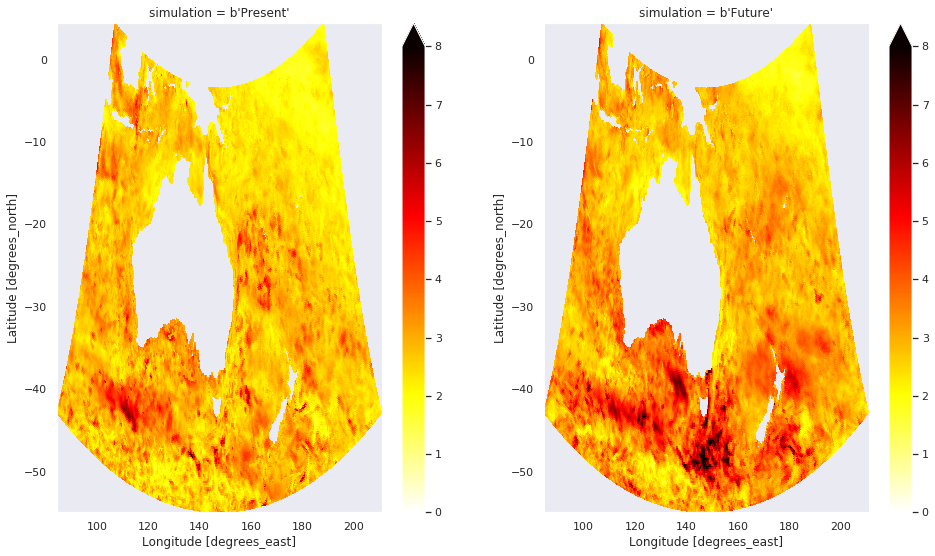

In [114]:
vmin = 0; vmax = 8;
f, (ax1, ax2) = plt.subplots(1, 2)
maxPastSev.plot(cmap = 'hot_r', ax = ax1, x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax);
maxFutSev.plot(cmap = 'hot_r',ax = ax2, x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax);

In [73]:
# Difference between past and future maximums. Also ensures that landmasses stay as nan.
max_diff = xr.where(maxFutSev == 0, np.nan, maxFutSev - maxPastSev)

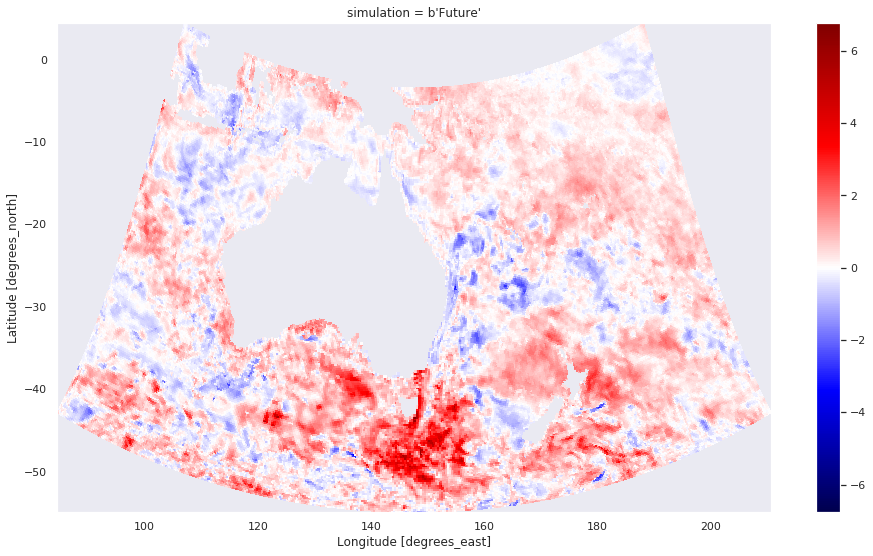

In [127]:
max_diff.plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic');

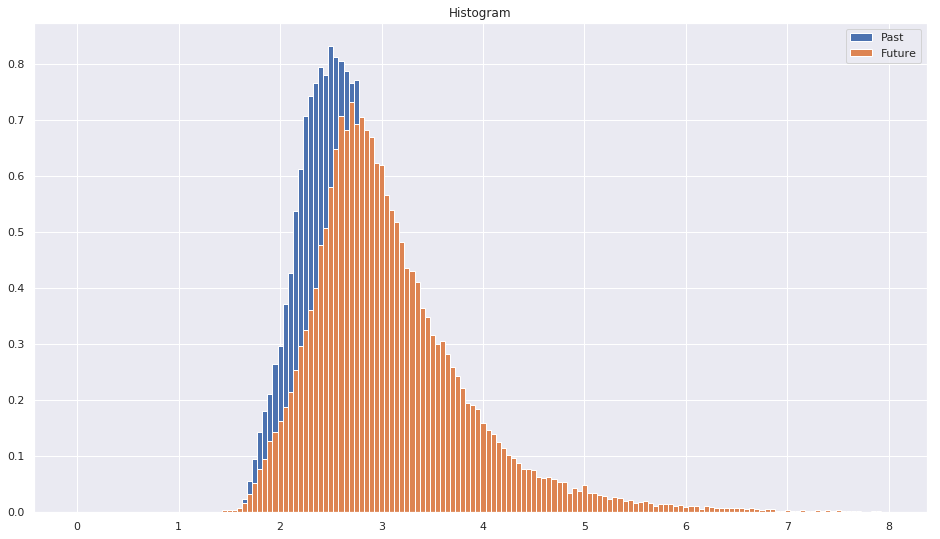

In [27]:
# Plots the frequencies/frequency density for each severity. 
bins = np.linspace(0,8,161)

# True if plotting densities, false if you want just frequency
pltDens = True

#f, (ax1, ax2) = plt.subplots(1, 2, sharey = True)

maxPastSev.plot.hist(align = 'left', bins = bins, density = pltDens, label = 'Past')#, ax = ax1);
maxFutSev.plot.hist(align = 'left',  bins = bins, density = pltDens, label = 'Future')#, ax = ax2);
plt.legend()
'''
ax1.set_title('Past Severity')
ax1.grid(True)
ax1.set_xlabel('Severity')

ax2.set_title('Future Severity');
ax2.grid(True);
ax2.set_xlabel('Severity');
''';

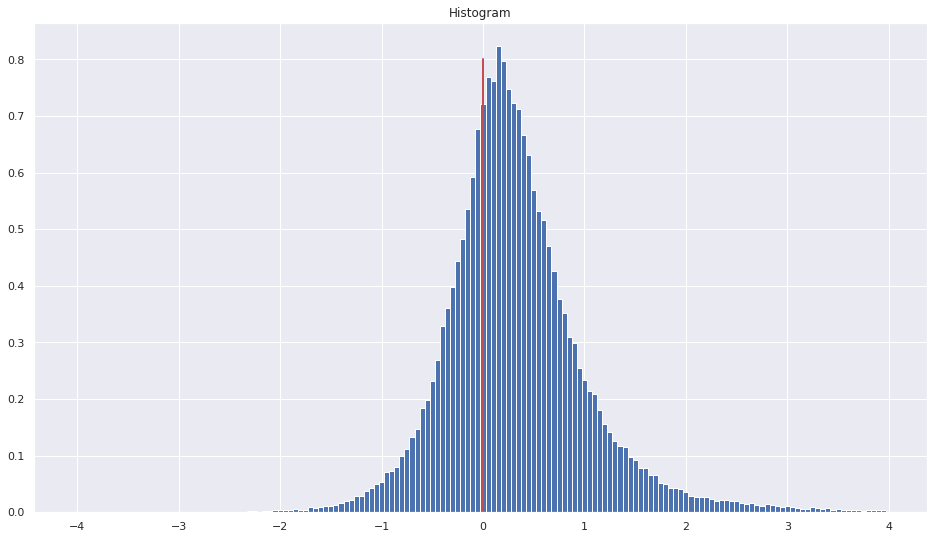

In [42]:
bins = np.linspace(-4, 4,161)
max_diff.plot.hist(align = 'left',  bins = bins, density = pltDens);
plt.plot(np.zeros(50), np.linspace(0, 0.8, 50), 'r', linewidth = 2);

### Calculating statistics for maximum Severity

In [34]:
# Calculating interquartile range
past_iqr = (maxPastSev.quantile(q = 0.75) - maxPastSev.quantile(q = 0.25)).data
fut_iqr = (maxFutSev.quantile(q = 0.75) - maxFutSev.quantile(q = 0.25)).data

In [35]:
# Comparing statistics
print("Past: std =", np.round(maxPastSev.std().data, 2), ", var =", np.round(maxPastSev.var().data,2),
      ", mean =", np.round(maxPastSev.mean().data,2), ", median =", np.round(maxPastSev.median().data,2),
     ", iqr =", np.round(past_iqr, 2))
print("Futu: std =", np.round(maxFutSev.std().data, 2), ", var =", np.round(maxFutSev.var().data,2),
     ", mean =", np.round(maxFutSev.mean().data,2),  ", median =", np.round(maxFutSev.median().data,2),
     ", iqr =", np.round(fut_iqr, 2))

Past: std = 0.62 , var = 0.38 , mean = 2.73 , median = 2.62 , iqr = 0.66
Futu: std = 0.83 , var = 0.69 , mean = 3.09 , median = 2.93 , iqr = 0.8


## Max SSTA - to be completed

In [138]:
# Finding max SSTA - TO BE COMPLETED
ssta = sstFut.chunk({'x':50, 'y':50, 'time_counter':365}) - fClim.chunk({'x':50, 'y':50, 'time_counter':365})
maxFutSSTA = ssta.chunk({'x' : 200, 'y' : 200}).max(dim = 'time_counter').compute()
maxFutSSTA.isel(x = slice(5,-5), y= slice(5,-25)).plot(cmap = 'hot_r');

NameError: name 'sstFut' is not defined

## Counting number of MHW days in each simulation

In [115]:
# Assigns a 1 for every mhw day, and sums along time dimension to calculate # of MHW days at each grid point.
pastDays = xr.where(pastMHW.isel(x = slice(5,-5), y = slice(5,-50)) > 0, 1, 0).sum('time_counter')
#Removes areas where the sum receives 0, or where there are no MHW days ever. This is should be all land.
pastDays = xr.where(pastDays == 0, np.nan, pastDays).compute()

In [116]:
# Same as above
futDays = xr.where(futMHW.isel(x = slice(5,-5), y = slice(5,-50)) > 0, 1, 0).sum('time_counter')
futDays = xr.where(futDays == 0, np.nan, futDays).compute()

In [46]:
print(futDays.sum().data/ pastDays.sum().data)
# Increase of 15% in MHW days!

1.1556853647325254


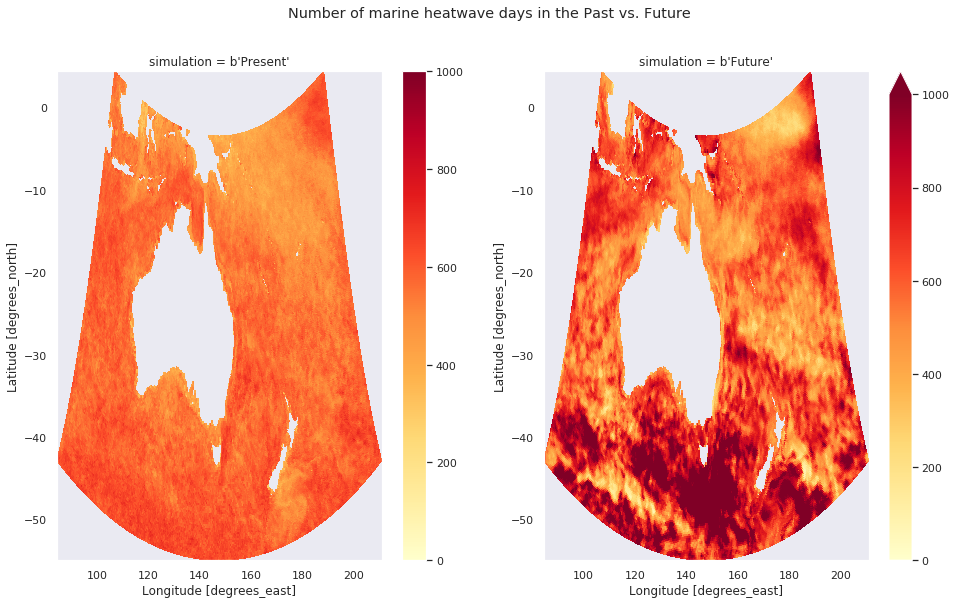

In [117]:
f, (ax1, ax2) = plt.subplots(1, 2)
vmin, vmax = (0, 1000)
f.suptitle('Number of marine heatwave days in the Past vs. Future');
pastDays.plot(x = 'nav_lon', y = 'nav_lat', ax = ax1, vmin = vmin, vmax = vmax, cmap = 'YlOrRd');
futDays.plot(x = 'nav_lon', y = 'nav_lat', ax = ax2, vmin = vmin, vmax = vmax, cmap = 'YlOrRd');

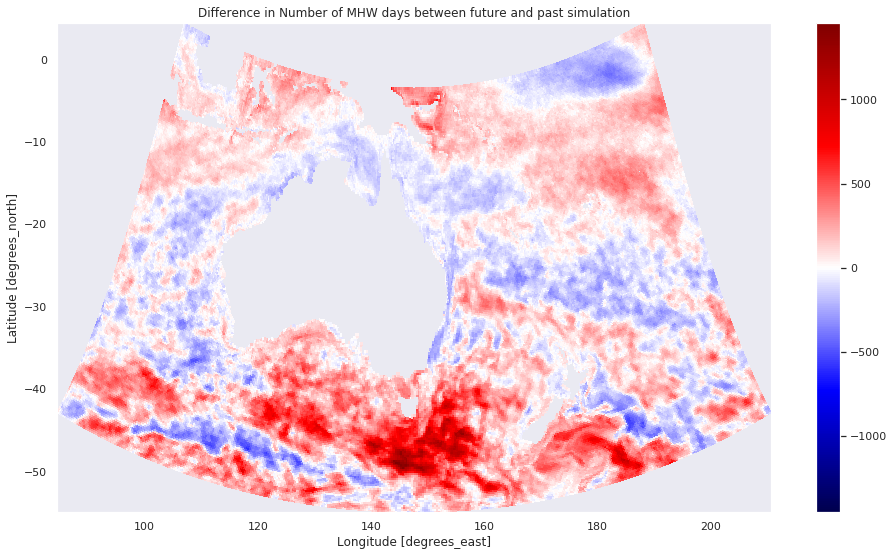

In [126]:
(futDays - pastDays).plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic');
plt.title('Difference in Number of MHW days between future and past simulation');

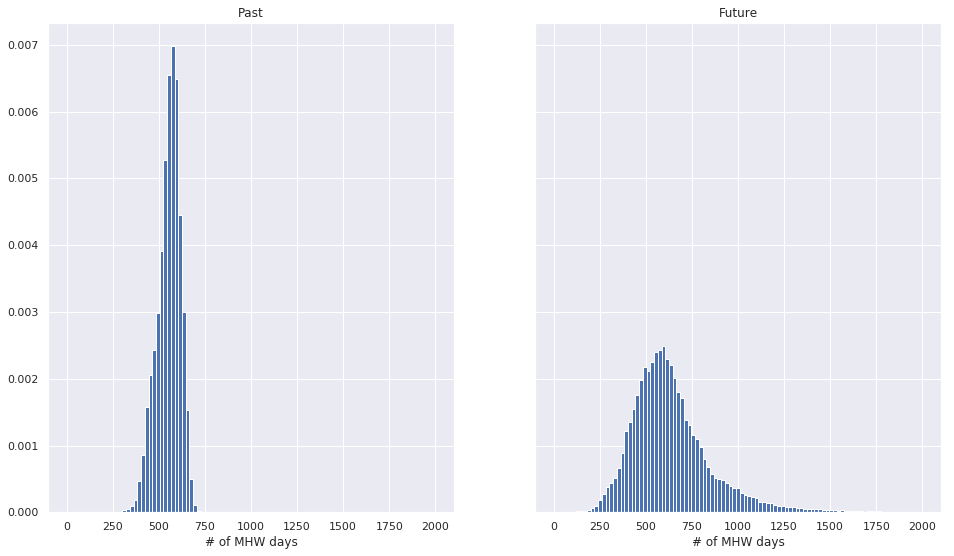

In [54]:
# Plots the frequencies/frequency density for each severity. 
bins = np.linspace(0,2000,100)

# True if plotting densities, false if you want just frequency
pltDens = True

f, (ax1, ax2) = plt.subplots(1, 2, sharey = True)

pastDays.plot.hist(align = 'mid', density = pltDens, bins = bins, label = 'Past', ax = ax1);
futDays.plot.hist(align = 'mid', density = pltDens, bins = bins, label = 'Future', ax = ax2);
#plt.legend()

ax1.set_title('Past')
ax1.grid(True)
ax1.set_xlabel('# of MHW days')

ax2.set_title('Future');
ax2.grid(True);
ax2.set_xlabel('# of MHW days');

## Number of days and max severity plotted together

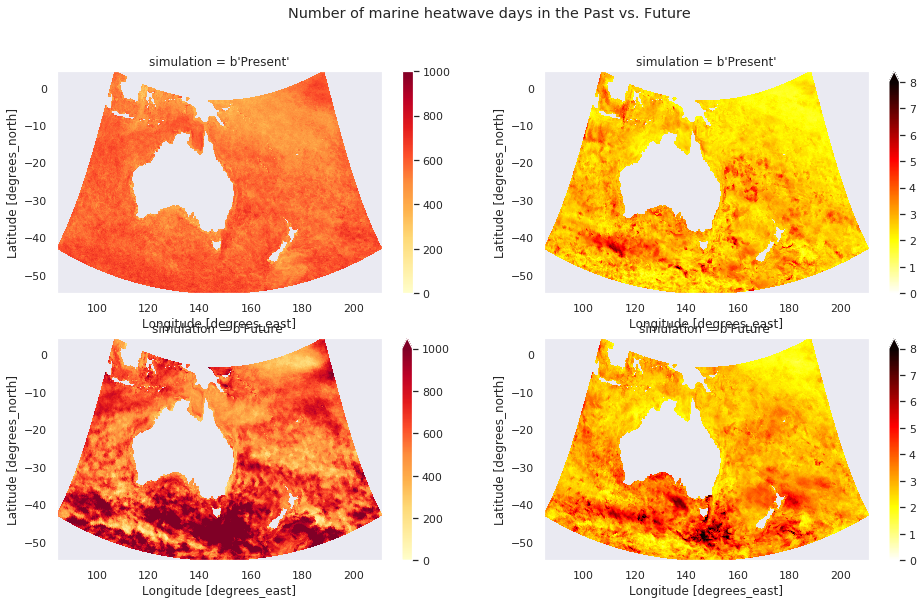

In [119]:
f, axs = plt.subplots(2, 2)
vmin1, vmax1 = (0, 1000)
vmin2, vmax2 = (0, 8);

f.suptitle('Number of marine heatwave days in the Past vs. Future');
pastDays.plot(x = 'nav_lon', y = 'nav_lat', ax = axs[0,0], vmin = vmin1, vmax = vmax1, cmap = 'YlOrRd');
maxPastSev.plot(cmap = 'hot_r', ax = axs[0,1], x = 'nav_lon', y = 'nav_lat', vmin = vmin2, vmax = vmax2);
futDays.plot(x = 'nav_lon', y = 'nav_lat', ax = axs[1,0], vmin = vmin1, vmax = vmax, cmap = 'YlOrRd');
maxFutSev.plot(cmap = 'hot_r',ax = axs[1,1], x = 'nav_lon', y = 'nav_lat', vmin = vmin2, vmax = vmax2);

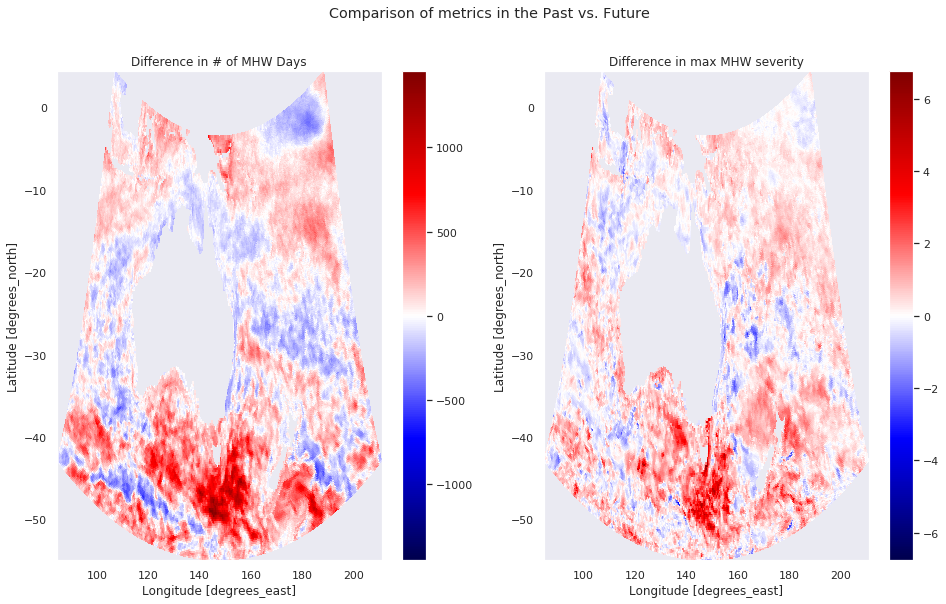

In [131]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.suptitle('Comparison of metrics in the Past vs. Future');

(futDays - pastDays).plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic', ax = ax1)
max_diff.plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic', ax = ax2)

ax1.set_title('Difference in # of MHW Days')
ax2.set_title('Difference in max MHW severity');

## Calculating the difference in mixed layer depth

In [132]:
cfg = 'present_vs_future.ini'
# mld = Mixed Layer Depth
mld = now.io.open_nemo_griddata_from_zarr(cfg, grid='T')['mldr10_1']

In [133]:
mld_past = mld.sel(simulation = 'Present').chunk({'time_counter' : t_chunk, 'x' : x_chunk, 'y' : y_chunk})
mld_fut = mld.sel(simulation = 'Future').chunk({'time_counter' : t_chunk, 'x' : x_chunk, 'y' : y_chunk})

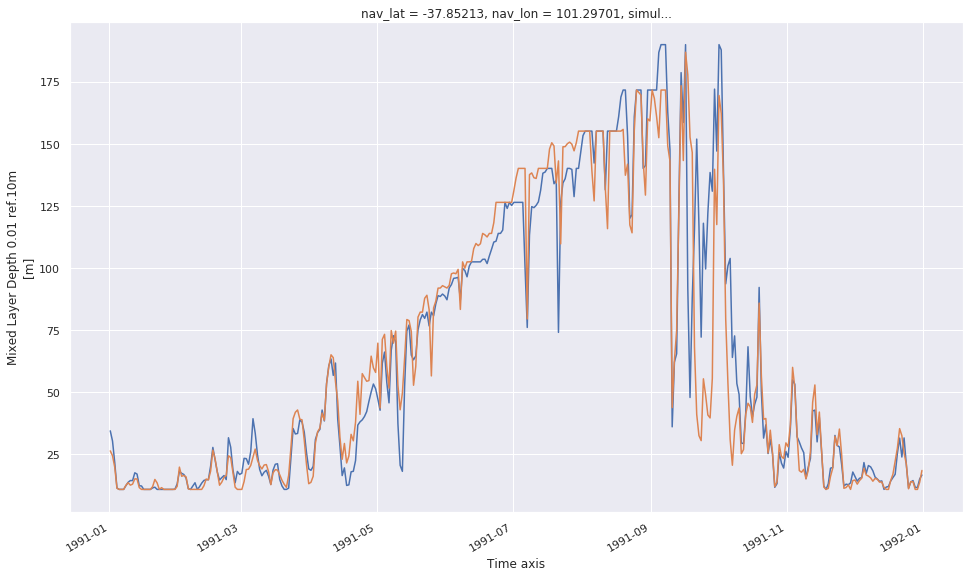

In [171]:
mld_past.isel(x = 50, y = 50, time_counter = slice(365, 365*2)).plot()
mld_fut.isel(x = 50, y = 50, time_counter = slice(365, 365*2)).plot();

In [151]:
# doy = day of year. Grouping together days of the year and averaging across them
doy_pastAve = mld_past.groupby('time_counter.dayofyear').mean(dim = 'time_counter').compute()
doy_futAve = mld_fut.groupby('time_counter.dayofyear')`.mean(dim = 'time_counter').compute()

In [135]:
# Rolling mean acts to smooth doy calculations
rollingMean_past = doy_pastAve.rolling(dayofyear = 11, center = True).mean().compute()
rollingMean_fut = doy_futAve.rolling(dayofyear = 11, center = True).mean().compute()

ValueError: For window size 11, every chunk should be larger than 5, but the smallest chunk size is 1. Rechunk your array
with a larger chunk size or a chunk size that
more evenly divides the shape of your array.

In [168]:
doy_dif = mld_fut - mld_past

In [169]:
doy_dif

<xarray.DataArray 'mldr10_1' (time_counter: 6940, y: 289, x: 431)>
dask.array<shape=(6940, 289, 431), dtype=float32, chunksize=(365, 90, 120)>
Coordinates:
    nav_lat          (y, x) float32 dask.array<shape=(289, 431), chunksize=(90, 120)>
    nav_lon          (y, x) float32 dask.array<shape=(289, 431), chunksize=(90, 120)>
  * time_counter     (time_counter) datetime64[ns] 1990-01-01T12:00:00 ... 2008-12-31T12:00:00
    time_maximum_1d  (time_counter) datetime64[ns] dask.array<shape=(6940,), chunksize=(365,)>
    time_minimum_1d  (time_counter) datetime64[ns] dask.array<shape=(6940,), chunksize=(365,)>
Dimensions without coordinates: y, x

In [156]:
max_doy_dif = doy_dif.max(dim = 'time_counter').compute()
min_doy_dif = doy_dif.min(dim = 'time_counter').compute()

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


In [163]:
mean_doy_dif = doy_dif.mean(dim = 'time_counter').compute()

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


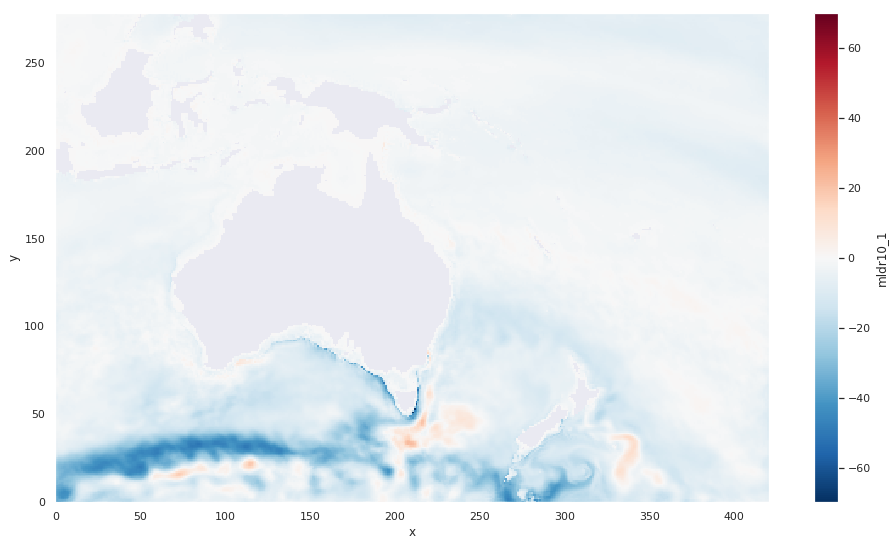

In [167]:
mean_doy_dif.isel(x = slice(5,-5), y = slice(5,-5)).plot();

In [146]:
max_doy_dif.plot()

<xarray.DataArray 'mldr10_1' (y: 289, x: 431)>
dask.array<shape=(289, 431), dtype=float32, chunksize=(90, 120)>
Coordinates:
    nav_lat  (y, x) float32 dask.array<shape=(289, 431), chunksize=(90, 120)>
    nav_lon  (y, x) float32 dask.array<shape=(289, 431), chunksize=(90, 120)>
Dimensions without coordinates: y, x